In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, IntegerLookup
from keras.models import Model
from keras import initializers
from keras.optimizers import SGD
import tensorflow_datasets as tfds
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2


In [3]:
prefs = pd.read_csv("ratings.csv", sep=",")
prefs.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
n_users = prefs.iloc[:,0].unique().size
n_items = prefs.iloc[:,1].unique().size
n_prefs = prefs.iloc[:,1].size

print("Number of users",n_users)
print("Number of items",n_items)
print("Number of prefs",n_prefs)

Number of users 610
Number of items 9724
Number of prefs 100836


#Different Architectures
**Architecture 1**

In [12]:
n_factors = 5

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

# Concatenate the embeddings 
conc = Concatenate()([user_embedding, item_embedding])
out = Dense(16)(conc)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = out,
)

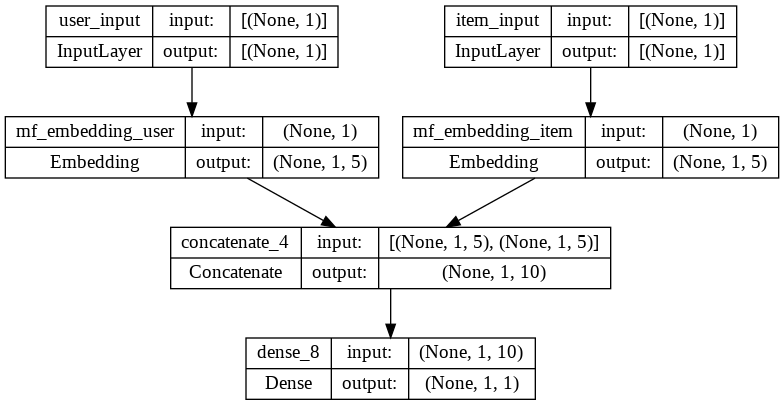

In [20]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

**Architecture 2**

- Vary the number of hidden units from 1 to 16. What do you observe in validation accuracy?
- Add more hidden layers. 
- Addtion a hidden layer (compared to architecture 1) clearly leads to better results. This cannot be compensated by increasing the number of units in the output layer in architecture 1.

In [21]:
n_factors = 5

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

# Concatenate the embeddings 
conc = Concatenate()([user_embedding, item_embedding])
fc1 = Dense(16)(conc)

out = Dense(1)(fc1)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = out,
)

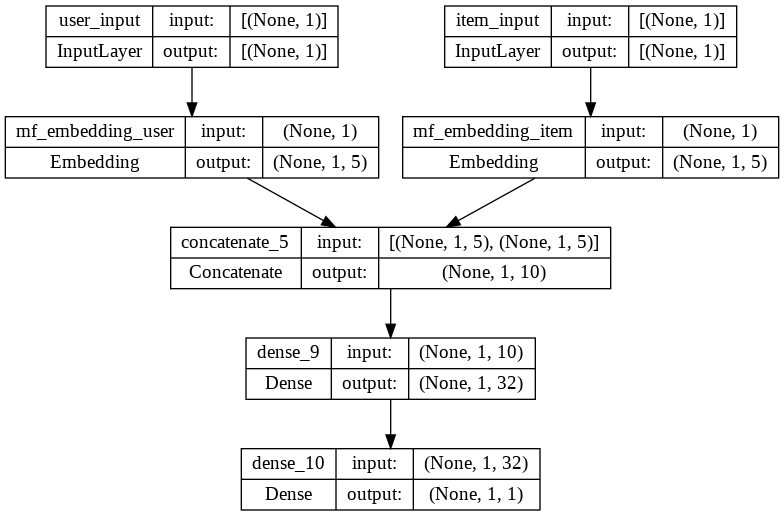

In [25]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

**Architecture 3**
- Dot product operation does not seem to have an additional advantage. Actually, it seems to make things worse.

In [7]:
n_factors = 5

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

user_factors = Flatten()(user_embedding)
item_factors = Flatten()(item_embedding)

# Concatenate the embeddings 
dot = Dot(axes=1)([user_factors, item_factors])
out = Dense(1)(dot)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = out,
)



In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [9]:
le = LabelEncoder()
x1 = le.fit_transform(prefs['userId'].values)
x2 = le.fit_transform(prefs['movieId'].values)

y = prefs.iloc[:,2]
#user_ids_vocabulary = tf.keras.layers.IntegerLookup(mask_token=None)
#user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

In [10]:
model.compile(
  loss='MSE',
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  metrics=['MAE'],
)
history = model.fit([x1,x2], y, epochs=5, validation_split=.05)

2994/2994 [==============================] - 6s 2ms/step - loss: 5.2547 - MAE: 1.9064 - val_loss: 3.8275 - val_MAE: 1.7822
Epoch 2/5
2994/2994 [==============================] - 6s 2ms/step - loss: 0.9071 - MAE: 0.7376 - val_loss: 2.5533 - val_MAE: 1.4238
Epoch 3/5
2994/2994 [==============================] - 6s 2ms/step - loss: 0.7629 - MAE: 0.6718 - val_loss: 2.2030 - val_MAE: 1.3084
Epoch 4/5
2994/2994 [==============================] - 5s 2ms/step - loss: 0.7225 - MAE: 0.6522 - val_loss: 2.1690 - val_MAE: 1.2962
Epoch 5/5
2994/2994 [==============================] - 5s 2ms/step - loss: 0.6891 - MAE: 0.6348 - val_loss: 2.1629 - val_MAE: 1.2942


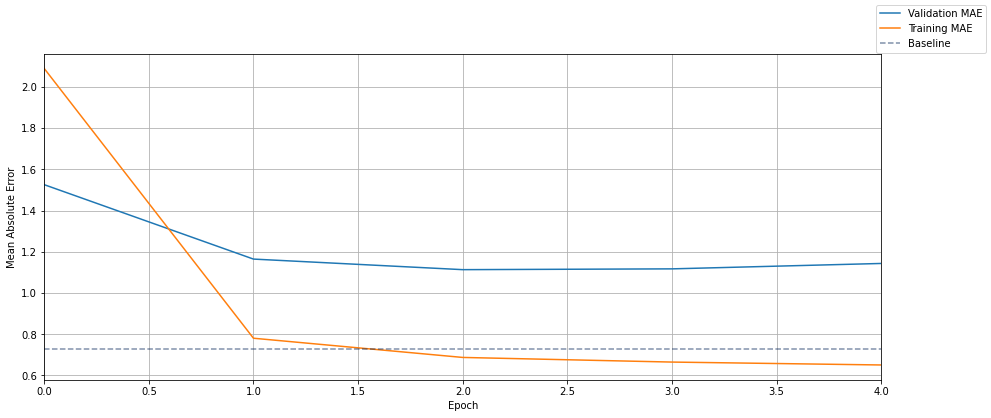

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();
